In [1]:
import sys
!{sys.executable} -m pip install tensorflow tensorflow-hub numpy matplotlib pillow

Defaulting to user installation because normal site-packages is not writeable


Import libraries

In [2]:

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")


TensorFlow version: 2.20.0
TensorFlow Hub version: 0.16.1


In [3]:
#Set up paths and split data

# Set paths
dataset_dir = "animals/animals"  # Your dataset folder
train_dir = "train"
test_dir = "test"
train_ratio = 0.8

# Create train/test folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data (run only once)
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)
    split_index = int(len(images) * train_ratio)

    train_images = images[:split_index]
    test_images = images[split_index:]

    # Create class folders
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy images
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("✅ Train/Test split completed!")

# Verify split
for dirpath, dirnames, filenames in os.walk(train_dir):
    if len(filenames) > 0:
        print(f"{dirpath}: {len(filenames)} images")

✅ Train/Test split completed!
train\antelope: 60 images
train\badger: 60 images
train\bat: 60 images
train\bear: 60 images
train\bee: 60 images
train\beetle: 60 images
train\bison: 60 images
train\boar: 60 images
train\butterfly: 60 images
train\cat: 60 images
train\caterpillar: 60 images
train\chimpanzee: 59 images
train\cockroach: 60 images
train\cow: 60 images
train\coyote: 60 images
train\crab: 60 images
train\crow: 60 images
train\deer: 60 images
train\dog: 60 images
train\dolphin: 60 images
train\donkey: 60 images
train\dragonfly: 60 images
train\duck: 60 images
train\eagle: 60 images
train\elephant: 60 images
train\flamingo: 60 images
train\fly: 60 images
train\fox: 60 images
train\goat: 60 images
train\goldfish: 60 images
train\goose: 60 images
train\gorilla: 60 images
train\grasshopper: 60 images
train\hamster: 60 images
train\hare: 60 images
train\hedgehog: 60 images
train\hippopotamus: 60 images
train\hornbill: 60 images
train\horse: 60 images
train\hummingbird: 60 images
tr

In [4]:
#Create data generators

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2
)

# Only rescaling for test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Get class names
class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)
print(f"\n✅ Found {num_classes} classes:")
print(class_names[:10], "...")  # Show first 10

Found 5398 images belonging to 90 classes.
Found 3590 images belonging to 90 classes.

✅ Found 90 classes:
['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat'] ...


In [5]:
#Build the model with proper custom layer

# Create a custom layer for TensorFlow Hub
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(
            "https://tfhub.dev/google/efficientnet/b0/feature-vector/1",
            trainable=False
        )
    
    def call(self, inputs):
        return self.hub_layer(inputs)
    
    def get_config(self):
        config = super().get_config()
        return config

# Build model
def create_model(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = HubLayer()(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create model
model = create_model(num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hub_layer (HubLayer)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 90)                  │         115,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,290 (450.35 KB)

 Trainable params: 115,290 (450.35 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
#Set up callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        "best_model.keras",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Save weights only
    ModelCheckpoint(
        "best_weights.weights.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks ready")

✅ Callbacks ready


In [8]:
#Train the model
# Train
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,  # Start with 30 epochs
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4005 - loss: 3.1573   
Epoch 1: val_accuracy improved from None to 0.91281, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras

Epoch 1: val_accuracy improved from None to 0.91281, saving model to best_weights.weights.h5

Epoch 1: finished saving model to best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 29508s 176s/step - accuracy: 0.6326 - loss: 2.1249 - val_accuracy: 0.9128 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.8789 - loss: 0.6877  
Epoch 2: val_accuracy improved from 0.91281 to 0.95209, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.91281 to 0.95209, saving model to best_weights.weights.h5

Epoch 2: finished saving model to best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8855 - loss: 0.6103 - val_accura

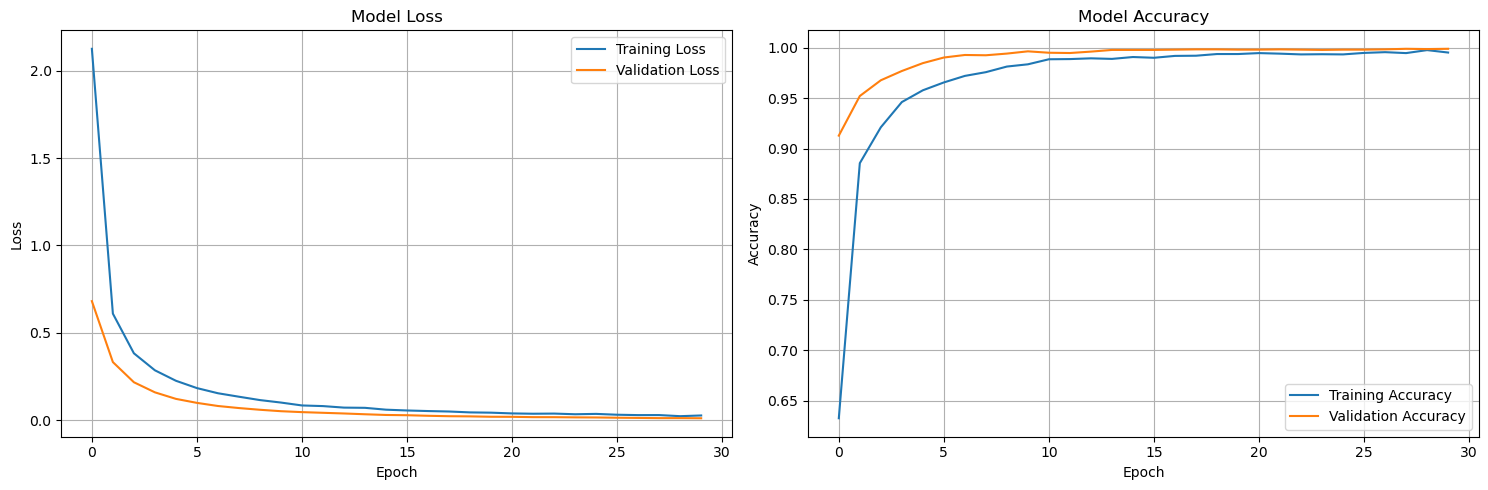


📊 Final Training Accuracy: 99.52%
📊 Final Validation Accuracy: 99.89%


In [9]:
#Plot training history

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final accuracy
print(f"\n📊 Final Training Accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"📊 Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2%}")

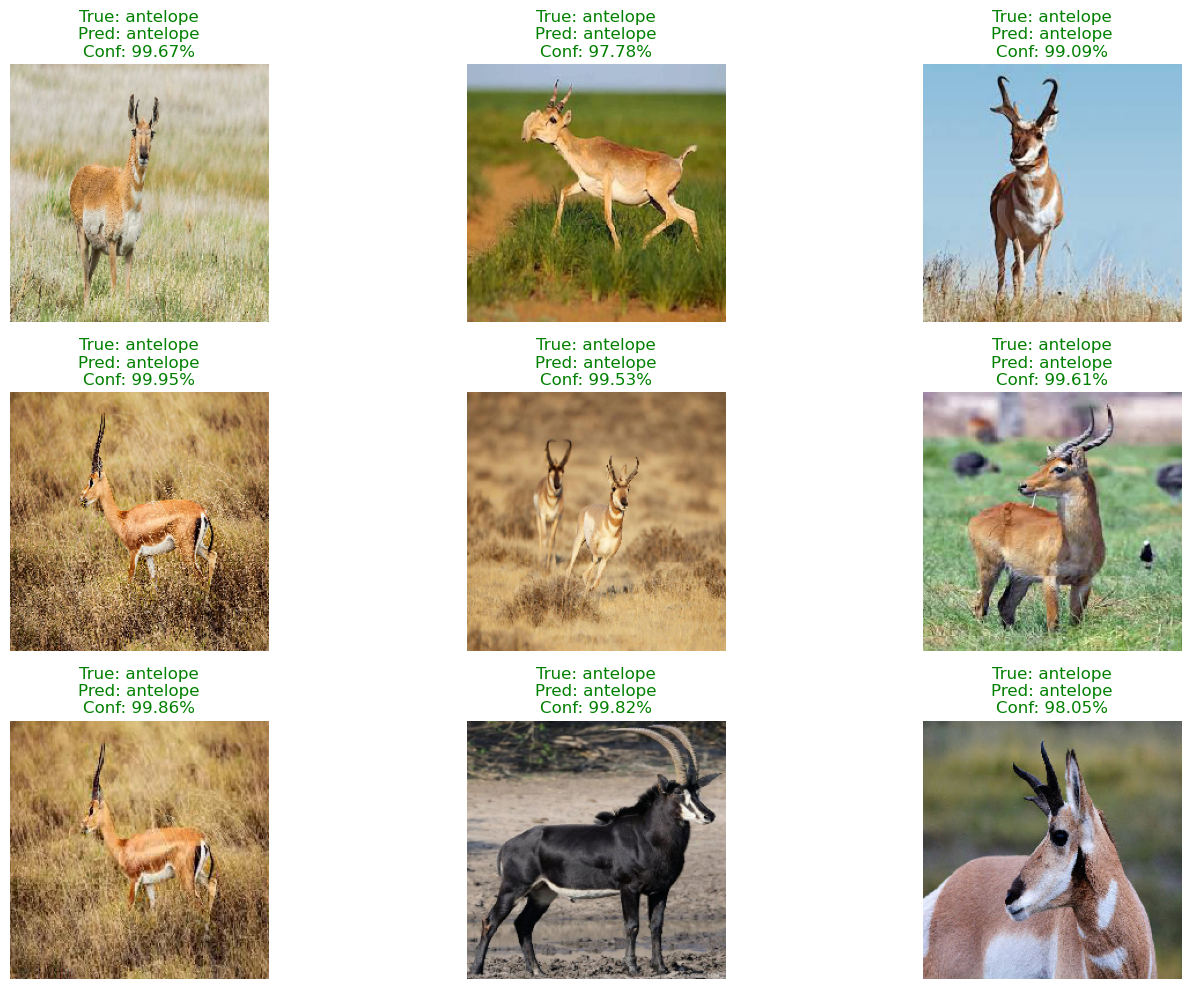

In [10]:
# Test the model on sample images
# Test on a batch of images
test_images, test_labels = next(iter(test_data))

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    
    # Get image and true label
    img = test_images[i]
    true_idx = np.argmax(test_labels[i])
    true_class = class_names[true_idx]
    
    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    pred_idx = np.argmax(pred)
    pred_class = class_names[pred_idx]
    confidence = pred[pred_idx]
    
    # Display
    plt.imshow(img)
    color = 'green' if pred_idx == true_idx else 'red'
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2%}", 
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
#Save the trained model in multiple formats
print("💾 Saving model in multiple formats...")
print("="*50)

# Load the best model from checkpoint
best_model = tf.keras.models.load_model(
    "best_model.keras",
    custom_objects={'HubLayer': HubLayer}
)

# Test best model
test_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
predictions = best_model.predict(test_input, verbose=0)[0]
print(f"\n📊 Best model confidence on random noise: {predictions.max():.2%}")

# Format 1: Save as Keras (with custom layer)
best_model.save("animal_classifier.keras")
size1 = os.path.getsize("animal_classifier.keras") / (1024 * 1024)
print(f"✅ Saved: animal_classifier.keras ({size1:.2f} MB)")

# Format 2: Save as H5
best_model.save("animal_classifier.h5")
size2 = os.path.getsize("animal_classifier.h5") / (1024 * 1024)
print(f"✅ Saved: animal_classifier.h5 ({size2:.2f} MB)")

# Format 3: Save weights only
best_model.save_weights("animal_classifier.weights.h5")
size3 = os.path.getsize("animal_classifier.weights.h5") / (1024 * 1024)
print(f"✅ Saved: animal_classifier.weights.h5 ({size3:.2f} MB)")

print("\n" + "="*50)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*50)
print("\n📋 Files created:")
print(f"   - best_model.keras (checkpoint)")
print(f"   - best_weights.weights.h5 (checkpoint weights)")
print(f"   - animal_classifier.keras ({size1:.2f} MB) - USE THIS FOR STREAMLIT")
print(f"   - animal_classifier.h5 ({size2:.2f} MB) - Alternative")
print(f"   - animal_classifier.weights.h5 ({size3:.2f} MB) - Backup weights")

💾 Saving model in multiple formats...



📊 Best model confidence on random noise: 32.17%
✅ Saved: animal_classifier.keras (1.34 MB)
✅ Saved: animal_classifier.h5 (1.34 MB)
✅ Saved: animal_classifier.weights.h5 (1.34 MB)

🎉 MODEL TRAINING COMPLETE!

📋 Files created:
   - best_model.keras (checkpoint)
   - best_weights.weights.h5 (checkpoint weights)
   - animal_classifier.keras (1.34 MB) - USE THIS FOR STREAMLIT
   - animal_classifier.h5 (1.34 MB) - Alternative
   - animal_classifier.weights.h5 (1.34 MB) - Backup weights


In [12]:
#Verify the saved model works

# Verify that the saved model loads correctly
print("🔍 Verifying saved model...")
print("="*50)

try:
    # Try loading the Keras model
    test_model = tf.keras.models.load_model(
        "animal_classifier.keras",
        custom_objects={'HubLayer': HubLayer}
    )
    
    # Test
    test_pred = test_model.predict(test_input, verbose=0)[0]
    print(f"✅ Keras model loaded successfully!")
    print(f"📊 Test confidence: {test_pred.max():.2%}")
    
    if test_pred.max() > 5:
        print("✅ Model has trained weights! Ready for Streamlit.")
    else:
        print("⚠️ Warning: Model confidence is low")
        
except Exception as e:
    print(f"❌ Error: {e}")

print("\n✅ All done! Now you can use 'animal_classifier.keras' in Streamlit.")

🔍 Verifying saved model...
✅ Keras model loaded successfully!
📊 Test confidence: 32.17%
⚠️ Warning: Model confidence is low

✅ All done! Now you can use 'animal_classifier.keras' in Streamlit.


In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pickle

print("🔍 EXTRACTING DENSE LAYER WEIGHTS")
print("="*50)

# Define the HubLayer class
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(
            "https://tfhub.dev/google/efficientnet/b0/feature-vector/1",
            trainable=False
        )
    
    def call(self, inputs):
        return self.hub_layer(inputs)

# Load the model
print("\n📂 Loading best_model.keras...")
try:
    tf.keras.config.enable_unsafe_deserialization()
    
    model = tf.keras.models.load_model(
        "best_model.keras",
        custom_objects={
            'HubLayer': HubLayer,
            'KerasLayer': hub.KerasLayer
        },
        safe_mode=False
    )
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Test the model
test_input = np.random.random((1, 224, 224, 3)).astype(np.float32)
predictions = model.predict(test_input, verbose=0)[0]
print(f"\n📊 Model confidence: {predictions.max():.2%}")

# Find and extract dense layer weights
print("\n🔍 Finding dense layer...")
dense_weights = None
dense_bias = None

for layer in model.layers:
    if 'dense' in layer.name.lower():
        print(f"✅ Found dense layer: {layer.name}")
        weights = layer.get_weights()
        if len(weights) >= 2:
            dense_weights = weights[0]  # Kernel weights
            dense_bias = weights[1]     # Bias
            print(f"   Weights shape: {dense_weights.shape}")
            print(f"   Bias shape: {dense_bias.shape}")
        break

if dense_weights is not None:
    # Save weights
    print("\n💾 Saving dense layer weights...")
    
    # Save as numpy file
    np.save("dense_weights.npy", dense_weights)
    np.save("dense_bias.npy", dense_bias)
    print("✅ Saved: dense_weights.npy, dense_bias.npy")
    
    # Save as pickle (alternative)
    with open("dense_weights.pkl", "wb") as f:
        pickle.dump({'weights': dense_weights, 'bias': dense_bias}, f)
    print("✅ Saved: dense_weights.pkl")
    
    # Save as text for inspection
    np.savetxt("dense_weights_shape.txt", dense_weights.shape, fmt='%s')
    print("✅ Saved: dense_weights_shape.txt")
    
    print(f"\n📊 Weights stats:")
    print(f"   Mean: {dense_weights.mean():.6f}")
    print(f"   Std: {dense_weights.std():.6f}")
    print(f"   Min: {dense_weights.min():.6f}")
    print(f"   Max: {dense_weights.max():.6f}")

print("\n✅ EXTRACTION COMPLETE!")

🔍 EXTRACTING DENSE LAYER WEIGHTS

📂 Loading best_model.keras...
✅ Model loaded successfully!



📊 Model confidence: 19.52%

🔍 Finding dense layer...
✅ Found dense layer: dense
   Weights shape: (1280, 90)
   Bias shape: (90,)

💾 Saving dense layer weights...
✅ Saved: dense_weights.npy, dense_bias.npy
✅ Saved: dense_weights.pkl
✅ Saved: dense_weights_shape.txt

📊 Weights stats:
   Mean: -0.039703
   Std: 0.112318
   Min: -0.580786
   Max: 0.372330

✅ EXTRACTION COMPLETE!
